<a href="https://colab.research.google.com/github/erikaminarikova/Ordinal_Sums/blob/main/Example_7_ordinal_sums_california_housing_3classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [2]:
import pygad
import numpy as np
import pandas as pd
import statistics
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [7]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: np.abs(row['value'] - row['target']), axis=1)
        fitness = 1.0 / sum(df['error'])
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 10

    sol_per_pop = 24
    num_genes = 12 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 3

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1],
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-5:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [10]:
def print_attr_coef(sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = data_reordered.drop(columns=['target']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in merge_list:
    print(list)

In [11]:
from sklearn.datasets import fetch_california_housing

#getting the data from sciki learn
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame

In [12]:
#identify outliers
z = np.abs(stats.zscore(df))
threshold = 3
#remove outliers
df_o = df[(z<3).all(axis=1)]

In [13]:
# normalize the data
columns = df_o.columns
scaler = MinMaxScaler()
model = scaler.fit_transform(df_o)
df_scaled = pd.DataFrame(model, columns = columns)

In [14]:
print(df.shape)
print(df_o.shape)

(20640, 9)
(19794, 9)


In [15]:
#define target attribute to 3 value logic
df_scaled['target'] = df_scaled.apply(lambda row: 1 if row['MedHouseVal']>0.6 else ((row['MedHouseVal']-0.3)/(0.6-0.3) if row['MedHouseVal']>0.3 else 0), axis = 1)



In [18]:
# Data priparation for graphical representation of fuzzy set high
# y = df_scaled['target'].values
# x = df_scaled['MedHouseVal'].values
x =[0,0.2,0.3,0.5,0.6,1]
y=[0,0,0,0.667,1,1]

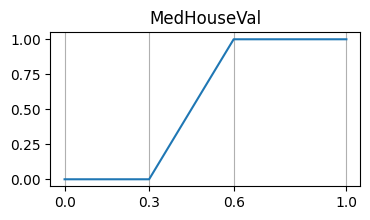

In [19]:
# Grafically represent fuzzy set high median house value
plt.figure(figsize=(4,2))
plt.xticks([0,0.3,0.6,1])
plt.grid(axis='x')
plt.plot(x,y)
plt.title('MedHouseVal')
plt.show()

In [20]:
df_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,target
count,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000
mean,0.356940,0.548464,0.379039,0.337248,0.278539,0.065694,0.329026,0.486415,0.386775,0.333279
std,0.177179,0.244083,0.105298,0.062056,0.168561,0.026643,0.227111,0.204472,0.228364,0.393189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225757,0.352941,0.307837,0.308126,0.163829,0.050492,0.147715,0.260204,0.213197,0.000000
50%,0.331276,0.549020,0.374044,0.327725,0.240656,0.062238,0.182784,0.596939,0.336289,0.120964
75%,0.459503,0.705882,0.441738,0.350689,0.351537,0.076327,0.550478,0.645918,0.505309,0.684364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


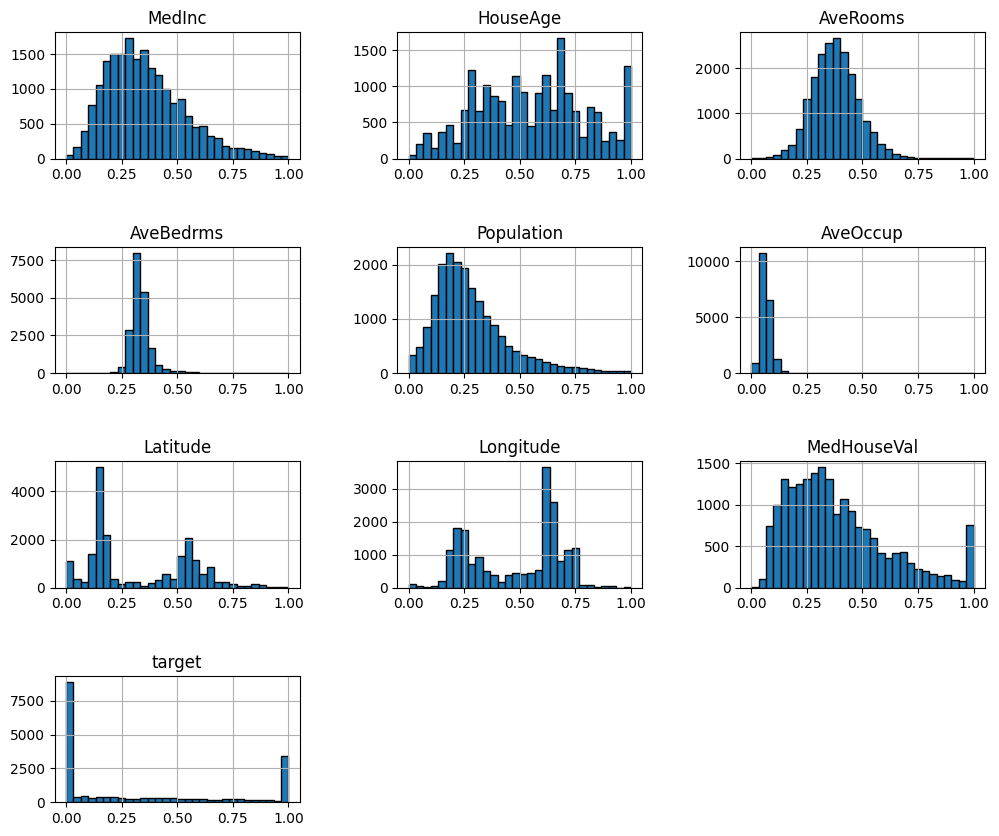

In [21]:
# Grafical representation of distribution of attributes
df_scaled.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [22]:
def plot_map(data):
  sns.scatterplot(
      data=data,
      x="Longitude",
      y="Latitude",
      size="MedHouseVal",
      hue="MedHouseVal",
      palette="viridis",
      alpha=0.5,
  )
  plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
  _ = plt.title("Median house value depending of\n their spatial location")

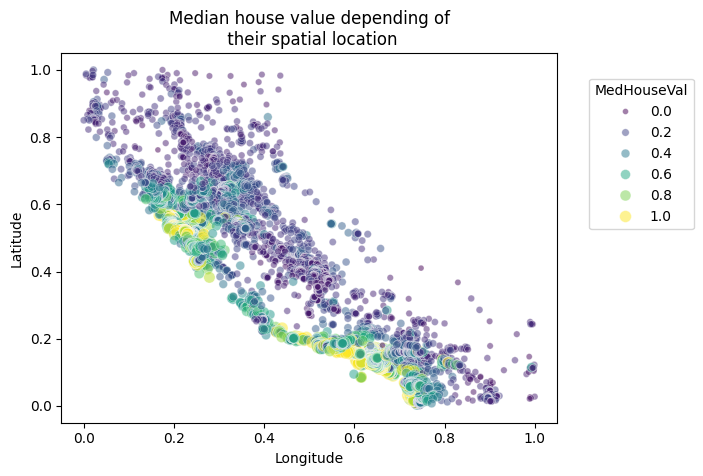

In [23]:
plot_map(df_scaled)

In [24]:
#prepare data for ordinal sums - identify target value - classification into 3 classes
data = df_scaled[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
data['target'] = df_scaled['target']

In [25]:
data_reordered = data.iloc[:,[1,2,3,4,5,6,7,0,8]]

In [26]:
data_reordered

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target
0,0.784314,0.529080,0.316547,0.066238,0.054379,0.567481,0.216327,0.864082,1.0
1,0.392157,0.464777,0.292740,0.497924,0.040955,0.565356,0.217347,0.861454,1.0
2,1.000000,0.641483,0.339303,0.102367,0.061810,0.564293,0.215306,0.746174,1.0
3,1.000000,0.428507,0.339125,0.115241,0.054150,0.564293,0.214286,0.567920,1.0
4,1.000000,0.468546,0.342803,0.116694,0.043113,0.564293,0.214286,0.369504,1.0
...,...,...,...,...,...,...,...,...,...
19789,0.470588,0.361971,0.366758,0.174834,0.054531,0.737513,0.332653,0.117091,0.0
19790,0.333333,0.454080,0.450404,0.073297,0.071464,0.738576,0.320408,0.227126,0.0
19791,0.313725,0.375770,0.360687,0.208472,0.047455,0.732200,0.319388,0.132517,0.0
19792,0.333333,0.386456,0.384447,0.153239,0.041358,0.732200,0.309184,0.150979,0.0


In [27]:
df_train, df_test = train_test_split(data_reordered, test_size=0.66, random_state=2)

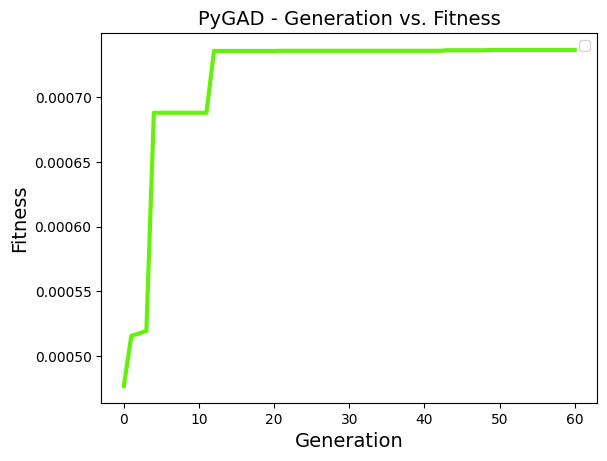

Results:
       HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
2563   0.627451  0.419414   0.301746    0.118355  0.050537  0.853348   
52     0.784314  0.312679   0.390317    0.406146  0.059357  0.561105   
18988  0.431373  0.394933   0.342125    0.111296  0.058175  0.850159   
16432  0.725490  0.514570   0.302184    0.279693  0.053838  0.519660   
17218  0.529412  0.409990   0.323061    0.437500  0.050624  0.505845   
...         ...       ...        ...         ...       ...       ...   
1099   0.431373  0.349409   0.314570    0.162998  0.043520  0.768332   
18898  0.490196  0.426587   0.316905    0.232973  0.069987  0.705632   
11798  0.137255  0.487566   0.473805    0.094269  0.046577  0.113709   
6637   0.490196  0.329658   0.337992    0.146595  0.103021  0.162593   
2575   0.294118  0.479153   0.599544    0.168812  0.052799  0.816153   

       Longitude    MedInc    target  calc_value  
2563    0.024490  0.219706  0.000000      0.0000  
52      0.212245  0.0674

In [28]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(sol_param)
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

In [29]:
#to know -2 or -5 in loop - remove additional columns
df_test

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target
5166,0.588235,0.291799,0.328154,0.318106,0.050678,0.159405,0.603061,0.283949,1.000000
18885,0.392157,0.287099,0.345432,0.309593,0.122093,0.699256,0.280612,0.092191,0.443300
17221,0.372549,0.402965,0.337405,0.423380,0.053526,0.507970,0.240816,0.464698,0.393128
18750,0.686275,0.341910,0.350643,0.424003,0.089395,0.538789,0.341837,0.195789,0.000000
8494,0.686275,0.427784,0.330500,0.232973,0.057323,0.136026,0.610204,0.609273,1.000000
...,...,...,...,...,...,...,...,...,...
9659,0.176471,0.345739,0.315455,0.072882,0.053567,0.702444,0.331633,0.390164,0.006876
14891,0.313725,0.484196,0.309359,0.231520,0.068663,0.062699,0.744898,0.417548,0.064607
5050,0.156863,0.271855,0.369975,0.090324,0.093127,0.148778,0.619388,0.043650,0.000000
14098,0.392157,0.530879,0.319385,0.335756,0.058730,0.028693,0.748980,0.534904,0.226806


In [30]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: row[0], axis =1)
# parameters for attributes
i=5
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], abs(row[j+1]-sol_param[i]), sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  i += 1
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

Results:
       HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
5166   0.588235  0.291799   0.328154    0.318106  0.050678  0.159405   
18885  0.392157  0.287099   0.345432    0.309593  0.122093  0.699256   
17221  0.372549  0.402965   0.337405    0.423380  0.053526  0.507970   
18750  0.686275  0.341910   0.350643    0.424003  0.089395  0.538789   
8494   0.686275  0.427784   0.330500    0.232973  0.057323  0.136026   
...         ...       ...        ...         ...       ...       ...   
9659   0.176471  0.345739   0.315455    0.072882  0.053567  0.702444   
14891  0.313725  0.484196   0.309359    0.231520  0.068663  0.062699   
5050   0.156863  0.271855   0.369975    0.090324  0.093127  0.148778   
14098  0.392157  0.530879   0.319385    0.335756  0.058730  0.028693   
6001   0.627451  0.460236   0.330638    0.171927  0.068422  0.161530   

       Longitude    MedInc    target  calc_value  
5166    0.603061  0.283949  1.000000      0.3093  
18885   0.280612  0.0921

In [31]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  #confucion matrif for 3 target classes
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])
  cm_display.plot()
  plt.show()

In [32]:
# label calculated value to the 3 clasees yes-1, no-0, maybe-2
merge_data['target_class'] = merge_data.apply(lambda row: 0 if (row['target']==0) else (1 if (row['target']==1) else 2), axis=1)
merge_data['calc_value_class'] = merge_data.apply(lambda row: 0 if (row['calc_value']==0) else (1 if row['calc_value'] ==1 else 2), axis=1)

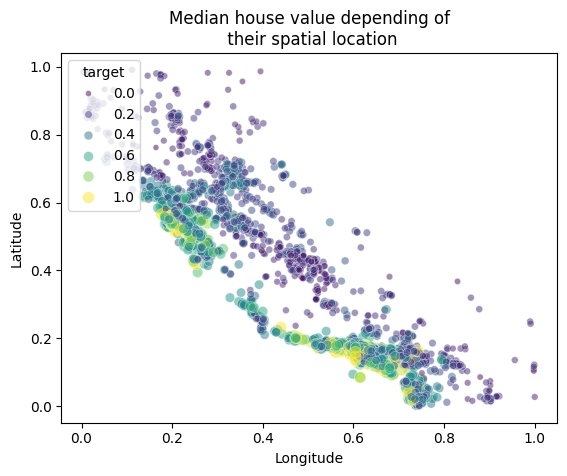

In [ ]:
sns.scatterplot(
      data=merge_data,
      x="Longitude",
      y="Latitude",
      size="target",
      hue="target",
      palette="viridis",
      alpha=0.5,
  )
plt.legend(title="target", loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

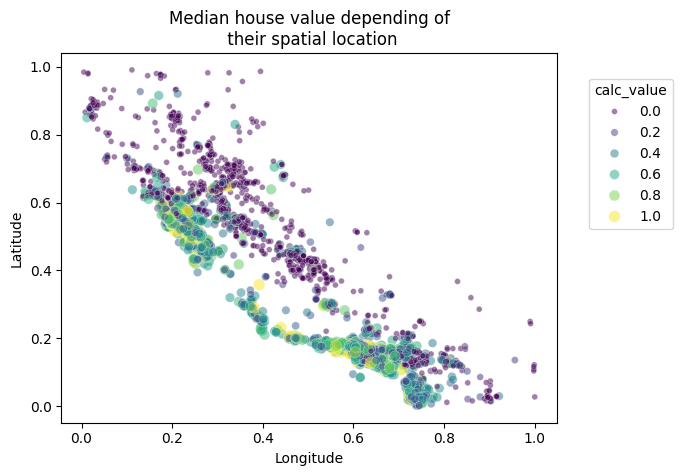

In [33]:
sns.scatterplot(
      data=merge_data,
      x="Longitude",
      y="Latitude",
      size="calc_value",
      hue="calc_value",
      palette="viridis",
      alpha=0.5,
  )
plt.legend(title="calc_value", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

In [34]:
#prepare data for tests
target_values = merge_data[['target_class']].values
value = merge_data[['calc_value_class']].values

Accuracy score =  0.6507653440332888
F1 =  0.5573352868622491
Precision =  0.7402203730200542
Recall =  0.556541842470847


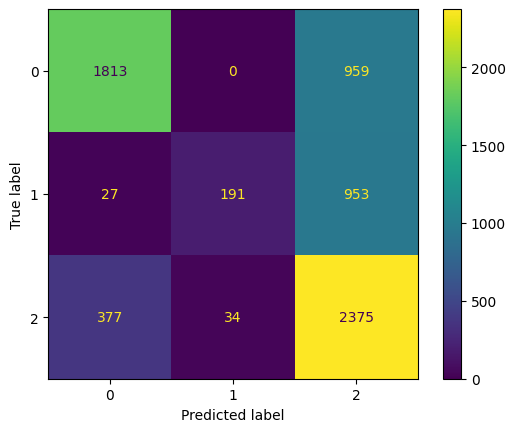

In [35]:
# tests for train dataset:
calculate_tests(target_values, value)

In [39]:
# label calculated value to the 3 clasees yes-1, no-0, maybe-2
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']==0) else (1 if (row['target']==1) else 2), axis=1)
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']==0) else (1 if row['calc_value'] ==1 else 2), axis=1)

In [40]:
#prepare test data for tests
target_values = df_test[['target_class']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.649062380405664
F1 =  0.5588974920989852
Precision =  0.7384318050195016
Recall =  0.5548951657062899


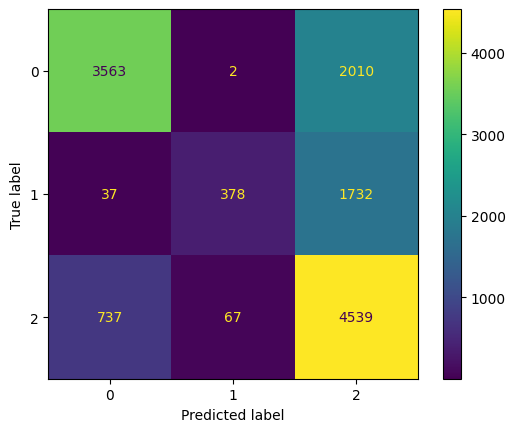

In [41]:
# tests for test dataset:
calculate_tests(target_values, value)

In [42]:
merge_data

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,value,error,calc_value,target_class,calc_value_class
2563,0.627451,0.419414,0.301746,0.118355,0.050537,0.853348,0.024490,0.219706,0.000000,0.0000,0.000000,0.0000,0,0
52,0.784314,0.312679,0.390317,0.406146,0.059357,0.561105,0.212245,0.067457,0.000000,0.0000,0.000000,0.2516,0,2
18988,0.431373,0.394933,0.342125,0.111296,0.058175,0.850159,0.125510,0.151244,0.000000,0.0000,0.000000,0.0000,0,0
16432,0.725490,0.514570,0.302184,0.279693,0.053838,0.519660,0.219388,0.758398,1.000000,0.2130,0.787000,0.7866,1,2
17218,0.529412,0.409990,0.323061,0.437500,0.050624,0.505845,0.240816,0.513284,1.000000,0.0000,1.000000,0.5323,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.431373,0.349409,0.314570,0.162998,0.043520,0.768332,0.278571,0.144939,0.000000,0.0000,0.000000,0.0000,0,0
18898,0.490196,0.426587,0.316905,0.232973,0.069987,0.705632,0.273469,0.319770,0.000000,0.0000,0.000000,0.0000,0,0
11798,0.137255,0.487566,0.473805,0.094269,0.046577,0.113709,0.803061,0.266867,0.000000,0.7210,0.721000,0.0000,0,0
6637,0.490196,0.329658,0.337992,0.146595,0.103021,0.162593,0.638776,0.295389,0.070793,0.5374,0.466607,0.0000,2,0


In [43]:
sum(merge_data['calc_value'] == 1)

225

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output.csv')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output_test.csv')

In [ ]:
#logistic regression for 3 target classes

In [44]:
from sklearn import linear_model

In [45]:
df_train

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,value,error,calc_value,target_class,calc_value_class
2563,0.627451,0.419414,0.301746,0.118355,0.050537,0.853348,0.024490,0.219706,0.000000,0.0000,0.000000,0.0000,0,0
52,0.784314,0.312679,0.390317,0.406146,0.059357,0.561105,0.212245,0.067457,0.000000,0.0000,0.000000,0.2516,0,2
18988,0.431373,0.394933,0.342125,0.111296,0.058175,0.850159,0.125510,0.151244,0.000000,0.0000,0.000000,0.0000,0,0
16432,0.725490,0.514570,0.302184,0.279693,0.053838,0.519660,0.219388,0.758398,1.000000,0.2130,0.787000,0.7866,1,2
17218,0.529412,0.409990,0.323061,0.437500,0.050624,0.505845,0.240816,0.513284,1.000000,0.0000,1.000000,0.5323,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.431373,0.349409,0.314570,0.162998,0.043520,0.768332,0.278571,0.144939,0.000000,0.0000,0.000000,0.0000,0,0
18898,0.490196,0.426587,0.316905,0.232973,0.069987,0.705632,0.273469,0.319770,0.000000,0.0000,0.000000,0.0000,0,0
11798,0.137255,0.487566,0.473805,0.094269,0.046577,0.113709,0.803061,0.266867,0.000000,0.7210,0.721000,0.0000,0,0
6637,0.490196,0.329658,0.337992,0.146595,0.103021,0.162593,0.638776,0.295389,0.070793,0.5374,0.466607,0.0000,2,0


In [46]:
#Reshaped for Logistic function.
X = df_train[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = df_train.apply(lambda row: 0 if (row['target']==0) else (1 if row['target'] ==1 else 2), axis=1).values

In [47]:
logr = linear_model.LogisticRegression()
logr.fit(X,y)

LogisticRegression()

In [48]:
predicted=logr.predict(X)

In [49]:
df_train['predicted'] = predicted

In [50]:
df_train

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,value,error,calc_value,target_class,calc_value_class,predicted
2563,0.627451,0.419414,0.301746,0.118355,0.050537,0.853348,0.024490,0.219706,0.000000,0.0000,0.000000,0.0000,0,0,0
52,0.784314,0.312679,0.390317,0.406146,0.059357,0.561105,0.212245,0.067457,0.000000,0.0000,0.000000,0.2516,0,2,0
18988,0.431373,0.394933,0.342125,0.111296,0.058175,0.850159,0.125510,0.151244,0.000000,0.0000,0.000000,0.0000,0,0,0
16432,0.725490,0.514570,0.302184,0.279693,0.053838,0.519660,0.219388,0.758398,1.000000,0.2130,0.787000,0.7866,1,2,1
17218,0.529412,0.409990,0.323061,0.437500,0.050624,0.505845,0.240816,0.513284,1.000000,0.0000,1.000000,0.5323,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.431373,0.349409,0.314570,0.162998,0.043520,0.768332,0.278571,0.144939,0.000000,0.0000,0.000000,0.0000,0,0,0
18898,0.490196,0.426587,0.316905,0.232973,0.069987,0.705632,0.273469,0.319770,0.000000,0.0000,0.000000,0.0000,0,0,0
11798,0.137255,0.487566,0.473805,0.094269,0.046577,0.113709,0.803061,0.266867,0.000000,0.7210,0.721000,0.0000,0,0,0
6637,0.490196,0.329658,0.337992,0.146595,0.103021,0.162593,0.638776,0.295389,0.070793,0.5374,0.466607,0.0000,2,0,0


In [53]:
# prepare dataset for testing
df_train['target_3classes'] = df_train.apply(lambda row: 0 if (row['target']==0) else (1 if row['target'] ==1 else 2), axis=1)

In [55]:
    # calculate the mean squared error
    target_values = df_train[['target_3classes']].values
    value = df_train[['predicted']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Mean squared error = ', MSE)
    print('Root Mean Square Error = ', RMSE)

Mean squared error =  0.7015901322633378
Root Mean Square Error =  0.8376097732615934


Accuracy score =  0.7411205231089315
F1 =  0.7102307810991663
Precision =  0.7622955597020121
Recall =  0.6899331811649593


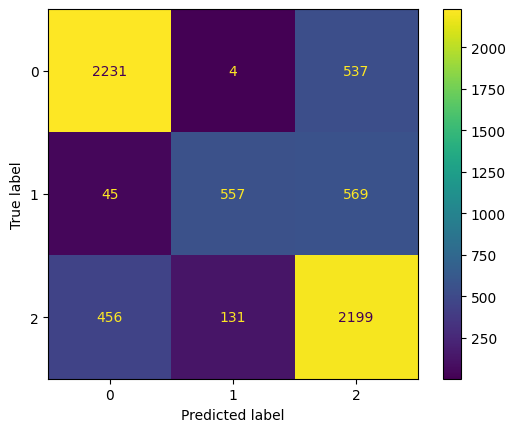

In [56]:
calculate_tests(target_values, value)

In [57]:
#Reshaped test data set for Logistic function.
X_t = df_test[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]

In [58]:
predicted_t = logr.predict(X_t)

In [61]:
X_t['predicted'] = predicted_t

In [60]:
X_t

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,presicted
5166,0.283949,0.588235,0.291799,0.328154,0.318106,0.050678,0.159405,0.603061,2
18885,0.092191,0.392157,0.287099,0.345432,0.309593,0.122093,0.699256,0.280612,0
17221,0.464698,0.372549,0.402965,0.337405,0.423380,0.053526,0.507970,0.240816,2
18750,0.195789,0.686275,0.341910,0.350643,0.424003,0.089395,0.538789,0.341837,0
8494,0.609273,0.686275,0.427784,0.330500,0.232973,0.057323,0.136026,0.610204,1
...,...,...,...,...,...,...,...,...,...
9659,0.390164,0.176471,0.345739,0.315455,0.072882,0.053567,0.702444,0.331633,0
14891,0.417548,0.313725,0.484196,0.309359,0.231520,0.068663,0.062699,0.744898,2
5050,0.043650,0.156863,0.271855,0.369975,0.090324,0.093127,0.148778,0.619388,0
14098,0.534904,0.392157,0.530879,0.319385,0.335756,0.058730,0.028693,0.748980,2


In [62]:
# prepare dataset for testing
df_test['target_3classes'] = df_test.apply(lambda row: 0 if (row['target']==0) else (1 if row['target'] ==1 else 2), axis=1)

In [63]:
    # calculate the mean squared error
    target_values = df_test[['target_3classes']].values
    value = X_t[['predicted']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Mean squared error = ', MSE)
    print('Root Mean Square Error = ', RMSE)

Mean squared error =  0.7527745885954841
Root Mean Square Error =  0.8676258344444823


Accuracy score =  0.7303482587064677
F1 =  0.6980199846014322
Precision =  0.7467814424199255
Recall =  0.6777414450556009


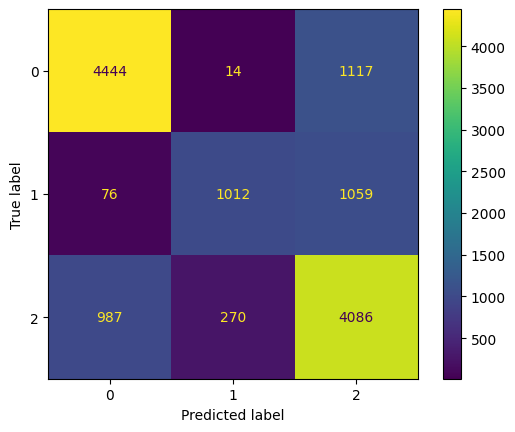

In [65]:
calculate_tests(target_values, value)